In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [122]:
df = pd.read_csv('bofa_ice_sovereign_bonds_returns.csv')

In [123]:
df = df.set_index('Unnamed: 0')

In [124]:
df.index = pd.to_datetime(df.index)

In [125]:
df = df.sort_index()

In [126]:
df = df.ffill().fillna(0).pct_change().fillna(0)

In [127]:
names = pd.read_csv('../Data/country_data/ice_bofa_sovereign_indices_summary.csv')

In [128]:
new_columns = {}

for i in range(len(names)):
    new_columns[(names['Index BBG Ticker']+' Index').loc[i]] = names['Full Index Name'].apply(lambda x: x.split(' ')[4]).loc[i]

In [129]:
X = df.copy()

In [130]:
X = X.replace(to_replace=float('inf'), value=0)

In [131]:
X = X.resample('W').sum()

In [133]:
def strategy(returns: pd.DataFrame, V_0=1, window=120, horizon=7, benchmark=False, GAMMA=1):
    V = V_0
    portfolio_value = [V]
    returns_value = [0]
    pnl = []
        
    # for each week we perform the optimisation
    for i in range(0, len(returns)-window-horizon, horizon):
        if benchmark:
            tradable = list(set(X.columns) - set(list(filter(lambda x: all(X[x].iloc[i:i+window] == 0.),  X.columns))+['GDZM Index']))
            w = np.ones(len(tradable))/len(tradable)
            temp = (returns.iloc[i+window:i+window+horizon][tradable] @ w)
            V *= (1+temp.sum())
        else:
            tradable = list(set(X.columns) - set(list(filter(lambda x: all(X[x].iloc[i:i+window] == 0.),  X.columns))+['GDZM Index']))
            inv_corr = np.linalg.inv(X.iloc[i:i+window][tradable].corr())
            num = np.dot(inv_corr, np.ones(len(inv_corr)))
            den = np.dot(np.ones(len(inv_corr)), inv_corr)@np.ones(len(inv_corr))
            num = list(map(lambda x: max(min(10, x), -10), num))
            w = np.array(num)/sum(num) if sum(num) != 0 else np.ones(len(tradable))/len(tradable)
            temp = (returns.iloc[i+window:i+window+horizon][tradable] @ w)
            V *= (1+temp.sum())
        portfolio_value.append(V)
        returns_value.append(portfolio_value[-1]/portfolio_value[-2]-1)
    return V, portfolio_value, returns_value

In [114]:
def plot_performance(value, rtns, title=None):
    fig, axs = plt.subplots(2, figsize=(12,6))
    fig.suptitle(title if title else 'Plot of portfolio value and returns over time')
    axs[0].plot(value)
    axs[1].plot(rtns)
    plt.show()

In [134]:
perf, value, rtns = strategy(X, window=5, horizon=1, benchmark=False)

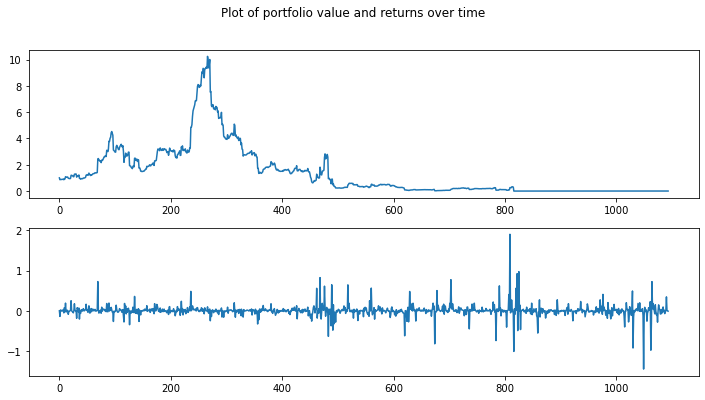

In [135]:
plot_performance(value, rtns)

In [ ]:
perf_bench, value_bench, rtns_bench = strategy(X, window=5, horizon=1, benchmark=True)

In [ ]:
plot_performance(value_bench, rtns_bench, title="Plot of benchmark value and returns over time")

In [173]:
def strategy(returns: pd.DataFrame, V_0=1, window=120, horizon=7, benchmark=False, GAMMA=1):
    V = V_0
    portfolio_value = [V]
    returns_value = [0]
    pnl = []
        
    # for each week we perform the optimisation
    for i in range(0, len(returns)-window-horizon, horizon):
        if benchmark:
            tradable = list(set(X.columns) - set(list(filter(lambda x: all(X[x].iloc[i:i+window] == 0.),  X.columns))))
            w = np.ones(len(tradable))/len(tradable)
            temp = (returns.iloc[i+window:i+window+horizon][tradable] @ w)
            V *= (1+temp.sum())
        else:
            tradable = list(set(X.columns) - set(list(filter(lambda x: all(X[x].iloc[i:i+window] == 0.),  X.columns))))
            try:
                inv_corr = np.linalg.inv(X.iloc[i:i+window][tradable].corr())
                num = np.dot(inv_corr, np.ones(len(inv_corr)))
                den = np.dot(np.ones(len(inv_corr)), inv_corr)@np.ones(len(inv_corr))
                num = list(map(lambda x: max(min(10, x), -10), num))
                w = np.array(num)/sum(num)
            except:
                w = np.ones(len(tradable))/len(tradable)
            temp = (returns.iloc[i+window:i+window+horizon][tradable] @ w)
            V *= (1+temp.sum())
        portfolio_value.append(V)
        returns_value.append(portfolio_value[-1]/portfolio_value[-2]-1)
    return V, portfolio_value, returns_value

In [137]:
equities = pd.read_csv('../Data/country_data/ETF_adj_close.csv')

In [138]:
equities = equities.rename(columns={'Unnamed: 0': 'trdate'})

In [139]:
equities = equities.set_index('trdate')
equities = equities.sort_index()

In [140]:
equities = equities.ffill().fillna(0).pct_change().fillna(0)

In [141]:
equities = equities.replace(to_replace=float('inf'), value=0)

In [142]:
X = equities.copy()

In [143]:
X.index = pd.to_datetime(X.index)

In [144]:
X = X.resample('W').sum()

In [145]:
X = X.replace(float('inf'), 0)

In [151]:
perf, value, rtns = strategy(X, window=30, horizon=1, benchmark=False)

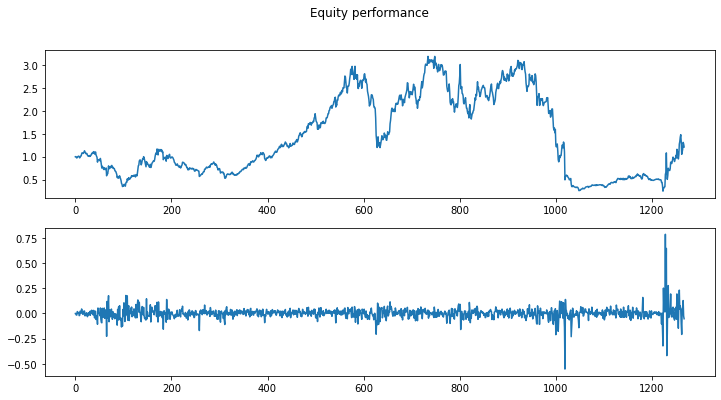

In [152]:
plot_performance(value, rtns, title="Equity performance")

In [153]:
perf_bench, value_bench, rtns_bench = strategy(X, horizon=1, benchmark=True)

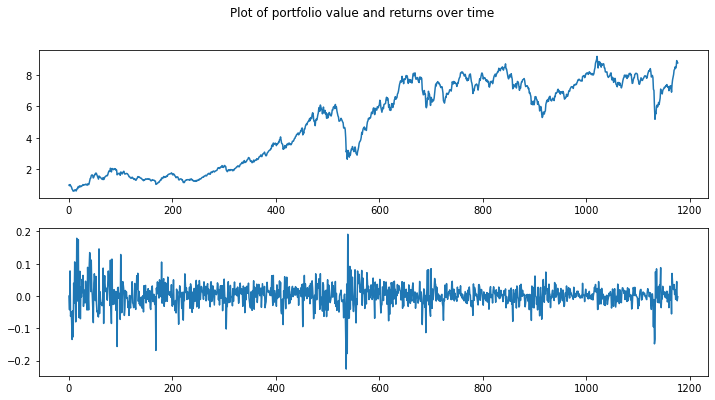

In [154]:
plot_performance(value_bench, rtns_bench)

## MVP on the clusters

In [167]:
equities_clusters = [['Pakistan', 'Saudi Arabia', 'Qatar', 'Egypt', 'United Arab Emirates'],
                     ['Argentina', 'Greece', 'South Africa', 'Brazil', 'Colombia'],
                     ['Turkey'],
                     ['Thailand', 'Taiwan', 'Russia', 'China', 'Peru', 'Mexico', 'Malaysia', 'Korea', 'India', 'Poland', 'Philippines']]

In [159]:
bond_clusters = [['Bulgaria', 'China', 'Hungary', 'South Korea', 'Malaysia', 'Pakistan', 'Poland', 'Tunisia', 'Ukraine', 'Venezuela'],
                 ['Bolivia'],
                 ['Brazil', 'Colombia', 'Indonesia', 'Mexico', 'Panama', 'Peru', 'Philippines', 'Russia', 'Turkey', 'Uruguay', 'Vietnam', 'South Africa'],
                 ['Chile', 'Costa Rica', 'Dominican Republic', 'Egypt', 'Guatemala', 'Israel', 'Jamaica', 'Lebanon', 'Qatar', 'El Salvador', 'Trinidad & Tobago']
                ]

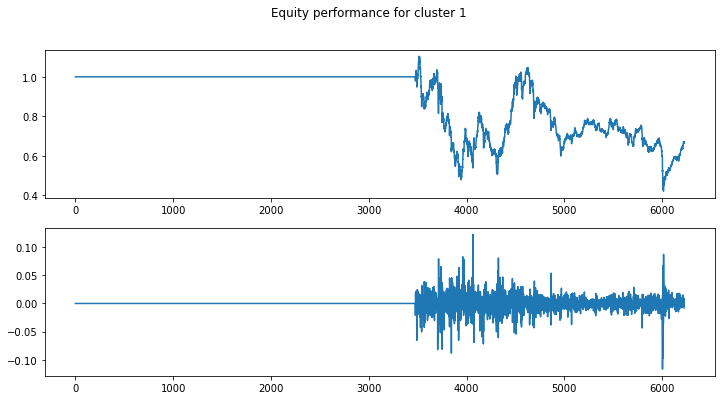

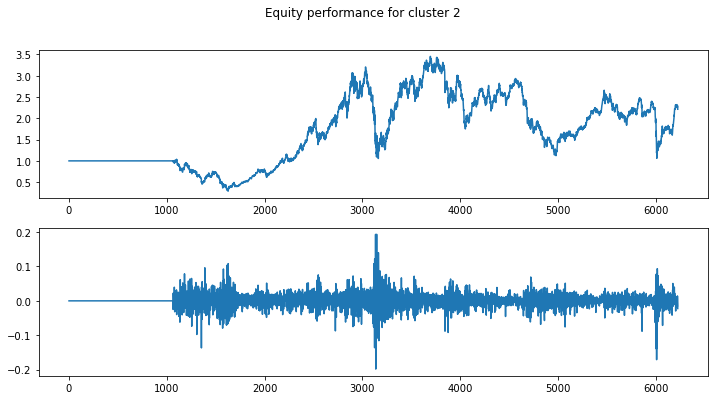

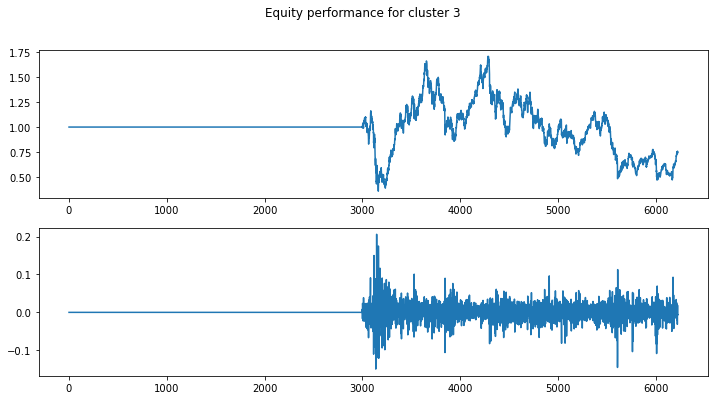

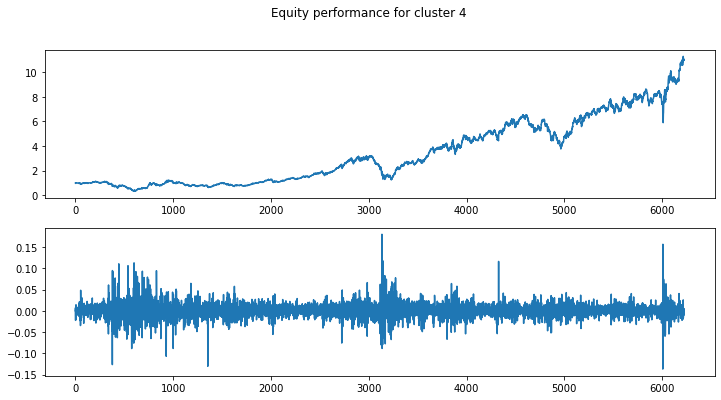

In [174]:
for i in range(4):
    X = equities[equities_clusters[i]].copy()
    perf, value, rtns = strategy(X, window=30, horizon=1, benchmark=False)
    plot_performance(value, rtns, title="Equity performance for cluster "+str(i+1))